<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">

# 6th exercise: <font color="#C70039">Work with Autoencoders for anomaly detection</font>
* Course: AML
* Lecturer: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>
* Author of notebook: <a href="https://www.gernotheisenberg.de/">Gernot Heisenberg</a>

* **Student: Tzu-Lun Yeh**
* **Matriculation Number: 11496498**
* **Date: 29.10.2025**

<img src="https://blog.keras.io/img/ae/autoencoder_schema.jpg" style="float: center;" width="700">

---------------------------------
**GENERAL NOTE 1**: 
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole. 

**GENERAL NOTE 2**: 
* Please, when commenting source code, just use English language only. 
* When describing an observation please use English language, too.
* This applies to all exercises throughout this course.

---------------------------------

### <font color="ce33ff">DESCRIPTION</font>:
Autoencoder is an unsupervised artificial neural network (ANN) that learns how to efficiently compress and encode data and then learns how to reconstruct the data back from the reduced encoded representation to a representation that is as close to the original input as possible.

An Autoencoder reduces data dimensions by learning how to ignore the noise in the data and thus outliers.
In the section above, you can seen an example of the input/output image from the MNIST dataset to an Autoencoder.

#### Autoencoder Components:
An Autoencoder consists of four main parts:

1. Encoder: In which the model learns how to reduce the input dimensions and compress the input data into an encoded representation.

2. Bottleneck: which is the layer that contains the compressed representation of the input data. This is the lowest possible dimensions of the input data. The bottlneck is also called latent vector. The concept of the latent space and latent vectors becomes important later on as we move forward to understand Generative Models. 

3. Decoder: In which the model learns how to reconstruct the data from the encoded representation to be as close to the original input as possible.

4. Reconstruction Loss: This is the method that measures how well the decoder is performing and how close the output is to the original input.

As always in ANNs, the training itself involves back propagation in order to minimize the network’s reconstruction loss.

Due to this features of an Autoencoder the use cases are manyfold. One of the obviously is anomaly detection. 

#### Autoencoder Architecture:

The network architecture for Autoencoders can vary between simple Feed Forward networks, Recurrent Neural Networks (LSTM) or Convolutional Neural Networks (CNN) depending on the use case. 

---------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points. 
If a task is more challenging and consists of several steps, this is indicated as well. 
Make sure you have worked down the task list and commented your doings. 
This should be done by using markdown.<br> 
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date. 
    * set the date too and remove mine.
3. read the entire notebook carefully 
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * the example below shows how to use an autoencoder for anomaly detection

4. <font color=green>Develop an Autoencoder for Domain Adaptation (Me -> Walter White ). You can of course also take own data, e.g. a photo of yours and someone else.</font>
5. Set at least the following hyperparameters for training (epochs=100000, shuffle=True).
6. Implement a CNN for working out important features for the adaptation. If you feel lost in the exercise, please visit the sample solution.
7. There is also an implementation of data augmentation that helps you building up your data set from one single "original" image. 
---------------------------------

### Auto-Encoding
If you have correlated input data, the auto-encoder method will work very well because the encoding operation relies on the correlated features to compress the data.
Let’s consider that an auto-encoder is trained on the MNIST dataset. 
As you know already, using a simple FeedForward neural network, this can be done by building a simple 6 layers network as below:

In [1]:
import numpy as np
import keras
from   keras.datasets import mnist
from   keras.models import Sequential, Model
from   keras.layers import Dense, Input
from   keras import optimizers
from   keras.optimizers import Adam

# load the inbuild mnist data set (8bit grayscale digits)
# https://en.wikipedia.org/wiki/MNIST_database
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# normalize the training and the validation data set
train_x = x_train.reshape(60000, 784) / 255
val_x = x_test.reshape(10000, 784) / 255

# build the auto-encoding layers
autoencoder = Sequential()
autoencoder.add(Dense(512,  activation='elu', input_shape=(784,)))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(10,   activation='linear', name="bottleneck"))
autoencoder.add(Dense(128,  activation='elu'))
autoencoder.add(Dense(512,  activation='elu'))
autoencoder.add(Dense(784,  activation='sigmoid'))
autoencoder.compile(loss='mean_squared_error', optimizer = Adam())

'''
NOTE:
-----
The Exponential Linear Unit (ELU) is an activation function for neural networks. 
In contrast to ReLUs (which you know), ELUs have negative values which allows them to push mean unit 
activations closer to zero like batch normalization but with lower computational complexity.
'''    

# train the model and finally assign the encoding to the decoder
'''
NOTE:
-----
make sure you understand, that you are training on train_x and not on train_y but train_x again for the reconstruction
the same for the validation (val_x, val_x)
'''
trained_model = autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10, verbose=1, validation_data=(val_x, val_x))

# Original code (doesn't work in Keras 3.x):
# encoder = Model(autoencoder.input, autoencoder.get_layer('bottleneck').output)

# Fix for Keras 3.x: Manually reconstruct the encoder by reusing trained layers
input_layer = Input(shape=(784,))
x = autoencoder.layers[0](input_layer)  # Dense(512)
x = autoencoder.layers[1](x)             # Dense(128)
bottleneck_output = autoencoder.layers[2](x)  # Dense(10, name='bottleneck')
encoder = Model(inputs=input_layer, outputs=bottleneck_output)

encoded_data = encoder.predict(train_x)  # bottleneck representation

decoded_output = autoencoder.predict(train_x)        # reconstruction
encoding_dim = 10

# return the decoder
encoded_input = Input(shape=(encoding_dim,))
decoder = autoencoder.layers[-3](encoded_input)
decoder = autoencoder.layers[-2](decoder)
decoder = autoencoder.layers[-1](decoder)
decoder = Model(encoded_input, decoder)

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-30 00:23:17.656133: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-30 00:23:17.656156: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-30 00:23:17.656160: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-30 00:23:17.656179: I tensorflow/core/common_

Epoch 1/10


2025-10-30 00:23:18.299107: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - loss: 0.1092 - val_loss: 0.0479
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0450 - val_loss: 0.0354
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0342 - val_loss: 0.0300
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0298 - val_loss: 0.0270
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0271 - val_loss: 0.0248
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0249 - val_loss: 0.0233
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0234 - val_loss: 0.0219
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0221 - val_loss: 0.0210
Epoch 9/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0212 - val_loss: 0.0203
Epoch 10/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 0.0204 - val_loss: 0.0196
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step


As you can see in the output, the last reconstruction loss/error for the validation set is approx. 0.0197, which is great. 
Now, if we pass any normal image from the MNIST dataset, the reconstruction loss will be very low (< 0.02) BUT if we tried to pass any other different image (outlier / anomaly), we will get a high reconstruction loss value because the network failed to reconstruct the image/input that is considered an anomaly.

Notice in the code above, you can use only the encoder part to compress some data or images and you can also only use the decoder part to decompress the data by loading the decoder layers.

#### Auto-Encoders for Anomaly Detection
Now, let’s do some anomaly detection. The code below uses two different images to predict the anomaly score (reconstruction error) using the autoencoder network we trained above. 

The first image is from the MNIST and the result is error=2.46241018. This means that the image is not an anomaly. The second image (yoda.png) obviously does not belong to the training dataset and the result is: error=2727.0718. This high error means that the image is an anomaly. Even the third image. The same concept applies to any type of dataset.

In [2]:
# If you are using a newer version of keras than '2.4.3', read this article below.
# It describes a versioning issue in the keras libs
'''https://stackoverflow.com/questions/72383347/how-to-fix-it-attributeerror-module-keras-preprocessing-image-has-no-attribu'''
#from keras.preprocessing import image
from keras.utils import load_img, img_to_array

# take an image from the validation data set or the training data set, respectively
input_img = val_x[50] 
input_img_flat = input_img.reshape(1,784)

target_data = autoencoder.predict(input_img_flat)

dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[2.81621897]


In [3]:
# Now take Master Yoda as the test image. The error score will be very high (error=2727.0718)
img = load_img("./data/yoda.png", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)
print(dist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[2727.3728]


In [4]:
''' 
Now take a Mnist image which is taken from the google image search and although it is super similar to the training data
it does not belong to the same data distribution the auto-encoder was trained on. 
It produces an error almost as high as yoda.png (approx error=2551.99)
This makes autoencoders being a very robust technique for anomaly detection.
'''
img = load_img("./data/similarMnistNumber.jpg", target_size=(28, 28), color_mode = "grayscale")
input_img = img_to_array(img)

input_img_flat = input_img.reshape(1,784)
target_data = autoencoder.predict(input_img_flat)
dist = np.linalg.norm(input_img_flat - target_data, axis=-1)

print(dist)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[2551.8987]


---
Learning Notes

**1. Data Flow & Dimensions**

Original MNIST: (10000, 28, 28) - 3D: 10000 images, each 28×28  
↓ reshape(10000, 784)  
Flattened: (10000, 784) - 2D (NOT 1D!) - 2 numbers in shape  
↓ val_x[50] (indexing reduces dimension)  
Single image: (784,) - 1D (only 1 number in shape)  
↓ reshape(1, 784)  
Ready for predict: (1, 784) - 2D again (2 numbers in shape)

Common Confusion:
- (10000, 784) is 1D? NO! It's 2D (has 2 dimensions)
- (784,) and (1, 784) are the same? NO! (784,) is 1D, (1, 784) is 2D
- Indexing reduces dimension: 2D array[i] → 1D element

**2. Why reshape(1, 784)?**

Problem: input_img.shape = (784,) - Just 784 numbers  
Keras gets confused: Is this 784 images with 1 pixel each? Or 1 image with 784 pixels?

Solution: input_img_flat.shape = (1, 784)  
Now Keras understands: batch_size = 1 (one image), features = 784 (784 pixels per image)

Rule: Keras ALWAYS needs (batch_size, features) format

**3. Why val_x[50]?**

val_x[50] just picks the 51st image (index starts at 0)  
Could be any number: val_x[0], val_x[100], val_x[9999]  
No special reason for "50" - just a random choice for demo

**4. Why Normalize by 255?**

Original: 0-255 (8-bit grayscale, 2^8 = 256 values)  
Normalized: 0.0-1.0 (divide by 255)

Why?
- Stable training (smaller gradients)
- Matches output layer (Sigmoid outputs 0-1)
- Faster convergence

**5. Training vs Prediction**

Training (fit):
- Process: Forward → Loss → Backward → Update
- Updates weights: YES
- Saves outputs: NO (discarded each batch)

Prediction (predict):
- Process: Forward only (no backward)
- Updates weights: NO (inference only)
- Saves outputs: YES (returned to you)

Critical: Training already processes all images, but outputs are discarded (not saved). Only weights are kept. Must predict again to get/save outputs.

**6. Complete Execution Flow**

Phase 1-2: Data Prep + Build Model  
↓  
Phase 3: Training (ONLY place weights are updated!)
- autoencoder.fit(train_x, train_x, batch_size=1024, epochs=10)
- 59 iterations/epoch × 10 epochs = 590 weight updates
- Loss: 0.1079 → 0.0200 (improved)

↓  
Phase 4: Extract Encoder (Keras 3.x fix)
- Manual reconstruction due to Sequential limitation
- Reuses trained weights (NO new training)

↓  
Phase 5: Predict on Training Set (OPTIONAL - can skip!)
- encoded_data = encoder.predict(train_x) → (60000, 10)
- decoded_output = autoencoder.predict(train_x) → (60000, 784)
- Variables defined but NOT USED in this notebook
- Output: 1875 batches (default batch_size=32)

↓  
Phase 6: Extract Decoder
- Reuses trained weights (NO new training)

↓  
Phase 7: Anomaly Detection (THE REAL GOAL!)
- Normal MNIST (val_x[50]): error = 2.80 (low error)
- Yoda image: error = 2727 (high error - anomaly!)
- Similar MNIST: error = 2552 (high error - different distribution)

**7. Key Confusions Clarified**

Q: Why not use (28, 28) instead of (784,)?  
A: Model was trained with input_shape=(784,). Dense layers require flattened 1D input. Must match training format! To use (28, 28): need CNN (Task 6)

Q: Why predict training set if we already trained on it?  
A: Training discards outputs, only keeps weights. If you want to save compressed/reconstructed data → must predict. In this notebook: variables unused, Phase 5 can be skipped

Q: Does predict() change weights?  
A: NO! Only fit() changes weights. predict() is forward-pass only (inference). Can run predict() 1000 times, weights stay the same

Q: Difference between code and "state"?  
Code: input_img = val_x[50]  
State: input_img.shape is now (784,) - result of execution  
When I say "shape = (784,)", I'm describing the result, not a line of code! Add print(input_img.shape) to verify.

Q: What is trained_model = autoencoder.fit(...)?  
A: Returns training history (loss, val_loss per epoch). Useful for: plotting training curves. In this notebook: unused

**8. Batch Size Difference**

Training: fit(..., batch_size=1024) → 60000 ÷ 1024 = 59 batches  
Prediction: predict(...) (default=32) → 60000 ÷ 32 = 1875 batches

Why different?
- We specified 1024 for training
- We didn't specify for predict → uses default (32)
- Both work fine! Batch size is just for processing efficiency

**9. reshape() is Universal**

reshape() changes array shape without changing data:

Examples:
- 3D → 2D: (10000, 28, 28) → reshape(10000, 784)
- 1D → 2D: (784,) → reshape(1, 784)
- 2D → 2D: (10000, 784) → reshape(784, 10000) (if needed)

Rule: Total elements must match!
- (28, 28) = 784 elements, can reshape to (784,)
- (28, 28) = 784 elements, can reshape to (1, 784)
- (28, 28) = 784 elements, cannot reshape to (100,) - wrong count!

**10. Summary Checklist**

- ONLY fit() trains (updates weights)
- ALL predict() calls are inference (no weight changes)
- Indexing reduces dimension: (N, M)[i] → (M,)
- (10000, 784) is 2D, NOT 1D
- (784,) is 1D, (1, 784) is 2D - different!
- Keras always needs: (batch_size, features)
- Must match training format (784 not 28×28)
- Phase 5 optional (can skip)
- val_x[50] just picks one image randomly

---
**Task 4-7: Domain Adaptation (Me → Walter White)**

Goal: Transform facial photos from Asian young male to Caucasian elderly male (Walter White style) using CNN autoencoder.

Dataset:
- Training: 300 images (150 me_aug + 150 walter_aug pairs), 256×256×3, normalized to [0, 1]
- Test: 3 original cropped images (not in training set)

In [2]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential
import os
from tqdm import tqdm
import time
import subprocess

# Set image size
SIZE = 256

print("Libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Image size: {SIZE}×{SIZE}")

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported successfully
TensorFlow version: 2.16.2
Image size: 256×256


In [3]:
# Load input images (ME - augmented photos)
input_img_data = []
input_path = './data/me_aug'
files = os.listdir(input_path)

print(f"Loading {len(files)} images from {input_path}...")
for i in tqdm(files):
    if not i.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img = cv2.imread(os.path.join(input_path, i), 1)
    if img is None:
        continue
    img = cv2.resize(img, (SIZE, SIZE))
    input_img_data.append(img_to_array(img))

# Load output images (WALTER - augmented photos)
output_img_data = []
output_path = './data/walter_aug'
files = os.listdir(output_path)

print(f"Loading {len(files)} images from {output_path}...")
for i in tqdm(files):
    if not i.lower().endswith(('.jpg', '.jpeg', '.png')):
        continue
    img = cv2.imread(os.path.join(output_path, i), 1)
    if img is None:
        continue
    img = cv2.resize(img, (SIZE, SIZE))
    output_img_data.append(img_to_array(img))

# Convert to numpy arrays and normalize
input_img_array = np.reshape(input_img_data, (len(input_img_data), SIZE, SIZE, 3))
input_img_array = input_img_array.astype('float32') / 255.0

output_img_array = np.reshape(output_img_data, (len(output_img_data), SIZE, SIZE, 3))
output_img_array = output_img_array.astype('float32') / 255.0

print(f"\nData loaded successfully")
print(f"Input shape: {input_img_array.shape}")
print(f"Output shape: {output_img_array.shape}")
print(f"Value range: [{input_img_array.min():.3f}, {input_img_array.max():.3f}]")

Loading 150 images from ./data/me_aug...


100%|██████████| 150/150 [00:00<00:00, 364.39it/s]


Loading 150 images from ./data/walter_aug...


100%|██████████| 150/150 [00:00<00:00, 633.05it/s]


Data loaded successfully
Input shape: (150, 256, 256, 3)
Output shape: (150, 256, 256, 3)
Value range: [0.000, 1.000]


In [13]:
# Build CNN Autoencoder Model
model = Sequential()

# Encoder
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))  # Bottleneck: 32×32

# Decoder
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer

# Compile with MAE loss
model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])
model.summary()

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 8)    │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

Train Model:

---
**Experiment 1: MAE + 1000 Epochs**

Rationale: Started with MAE expecting clearer generated images

Strategy: Train for 1000 epochs, save checkpoint every 100 epochs to monitor convergence

Configuration:
- Loss: mean_absolute_error (L1)
- Epochs: 1000, Batch: 32, Shuffle: True, Optimizer: Adam
- Checkpoints: Every 100 epochs

Architecture:
- Input: 256×256×3
- Encoder: Conv2D(32)→MaxPool → Conv2D(8)→MaxPool → Conv2D(8)→MaxPool (32×32 bottleneck)
- Decoder: Conv2D(8)→UpSample → Conv2D(8)→UpSample → Conv2D(32)→UpSample → Conv2D(3, sigmoid)
- Parameters: 8,163

Build Model:

In [ ]:
# Training Configuration
epochs = 1000
start = time.time()

print(f"Starting training: {epochs} epochs, {len(input_img_array)} images\n")

# Prevent system sleep
caffeinate_process = subprocess.Popen(['caffeinate', '-disu'], 
                                       stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
print(f"Caffeinate started (PID: {caffeinate_process.pid})\n")

try:
    # Custom callback: save every N epochs
    class PeriodicCheckpoint(tf.keras.callbacks.Callback):
        def __init__(self, filepath, period=100):
            super().__init__()
            self.filepath = filepath
            self.period = period
        
        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.period == 0:
                filepath = self.filepath.format(epoch=epoch+1)
                self.model.save(filepath)
                print(f'\nEpoch {epoch+1}: saving model to {filepath}')
    
    # Callbacks
    checkpoint_best = tf.keras.callbacks.ModelCheckpoint(
        'best_model_me_to_walter.keras', monitor='loss', save_best_only=True, verbose=1)
    checkpoint_periodic = PeriodicCheckpoint('checkpoint_epoch_{epoch:06d}.keras', period=100)
    
    # Train
    history = model.fit(input_img_array, output_img_array,
                        batch_size=32, epochs=epochs, shuffle=True,
                        callbacks=[checkpoint_best, checkpoint_periodic], verbose=1)
    
    # Results
    finish = time.time()
    training_time = finish - start
    hours = int(training_time // 3600)
    minutes = int((training_time % 3600) // 60)
    seconds = int(training_time % 60)
    
    print(f"\nTraining completed")
    print(f"Time: {hours}h {minutes}m {seconds}s")
    print(f"Final loss: {history.history['loss'][-1]:.6f}")
    print(f"Best loss: {min(history.history['loss']):.6f}")
    
    # Save final model
    model.save(f"final_model_me_to_walter_epochs_{epochs}.keras")
    print(f"Final model saved")

finally:
    # Stop caffeinate
    caffeinate_process.terminate()
    caffeinate_process.wait()
    print(f"\nCaffeinate stopped")

Training Results:

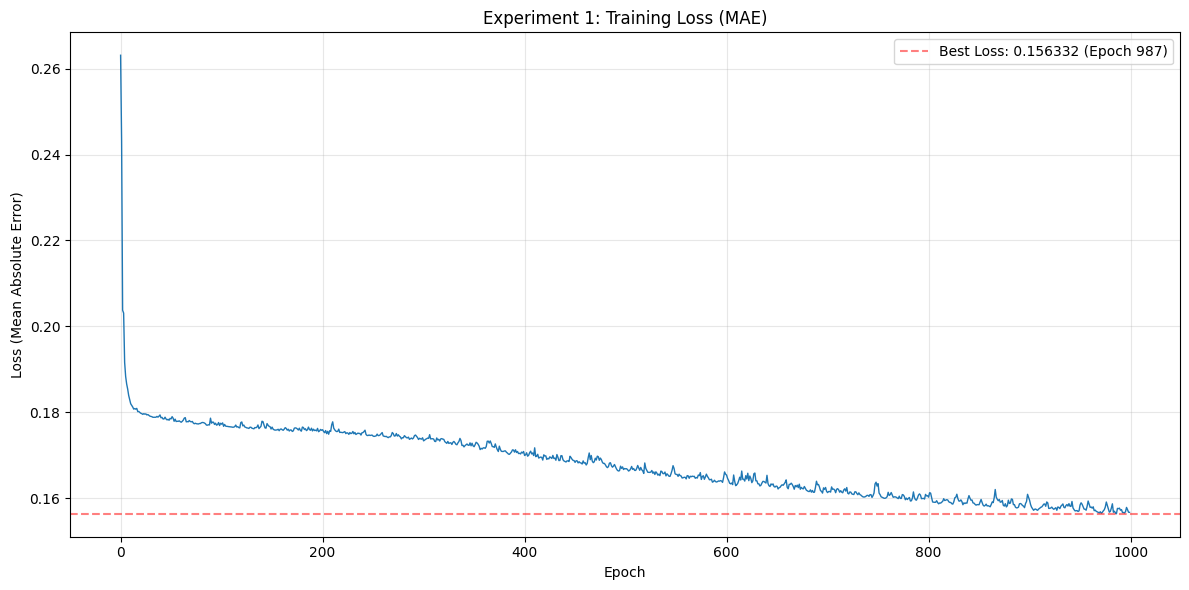


Training Statistics:
   Initial loss:  0.263117
   Final loss:    0.156668
   Best loss:     0.156332 (Epoch 987)
   Improvement:   40.5%


In [16]:
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], linewidth=1)
plt.title('Experiment 1: Training Loss (MAE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Absolute Error)')
plt.grid(True, alpha=0.3)

# Add statistics
min_loss = min(history.history['loss'])
min_epoch = history.history['loss'].index(min_loss)
plt.axhline(y=min_loss, color='r', linestyle='--', alpha=0.5, 
            label=f'Best Loss: {min_loss:.6f} (Epoch {min_epoch+1})')
plt.legend()

plt.tight_layout()
plt.savefig('training_loss_curve.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nTraining Statistics:")
print(f"   Initial loss:  {history.history['loss'][0]:.6f}")
print(f"   Final loss:    {history.history['loss'][-1]:.6f}")
print(f"   Best loss:     {min_loss:.6f} (Epoch {min_epoch+1})")
print(f"   Improvement:   {((history.history['loss'][0] - history.history['loss'][-1]) / history.history['loss'][0] * 100):.1f}%")

Test Results:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step


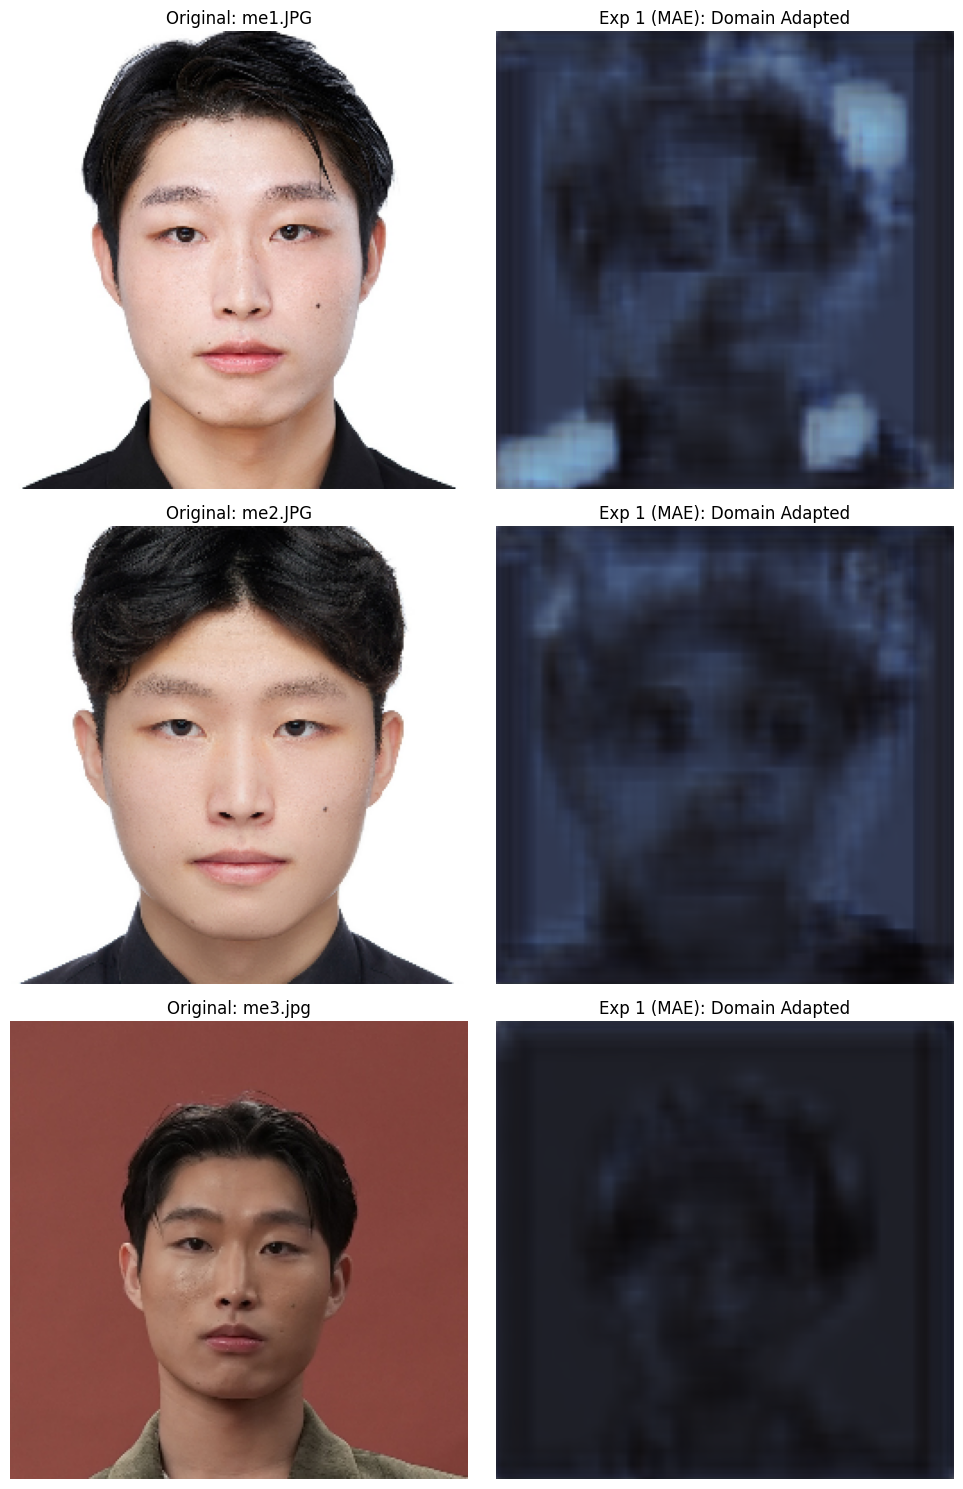

Results saved: domain_adaptation_results_exp1.png


In [30]:
# Load trained model
model = tf.keras.models.load_model('Ex6.Model_mae/checkpoint_epoch_000400.keras')

# Load test images
test_img_data = []
test_path = './data/me_cropped'
test_files = sorted([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])

for filename in test_files:
    img = cv2.imread(os.path.join(test_path, filename), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (SIZE, SIZE))
    test_img_data.append(img_to_array(img))

test_img_array = np.array(test_img_data).astype('float32') / 255.0

# Predict
predictions = model.predict(test_img_array)

# Visualize
fig, axes = plt.subplots(len(test_files), 2, figsize=(10, 5 * len(test_files)))
if len(test_files) == 1:
    axes = axes.reshape(1, -1)

for i in range(len(test_files)):
    axes[i, 0].imshow(test_img_array[i])
    axes[i, 0].set_title(f'Original: {test_files[i]}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(predictions[i])
    axes[i, 1].set_title(f'Exp 1 (MAE): Domain Adapted')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('domain_adaptation_results_exp1.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Results saved: domain_adaptation_results_exp1.png")

Observations:

Checkpoint Comparison:
- Compared output quality across all checkpoints (every 100 epochs)
- Models around epoch 400-500 present better visual results than others
- Loss continues decreasing, but image quality peaks around this range

Output Quality:
- Significant blur and blue artifacts
- Face shape captured but details lost
- Result not good enough despite optimal epoch selection

Decision: Switch to MSE loss function for Experiment 2

Output Files: best_model_me_to_walter.keras, checkpoint_epoch_*.keras (every 100 epochs), final_model_me_to_walter_epochs_1000.keras, training_loss_curve.png, domain_adaptation_results_exp1.png

---
**Experiment 2: MSE + 500 Epochs**

Rationale: 
- Exp 1 results not satisfactory (blur + artifacts)
- Switch to MSE loss function expecting better reconstruction quality
- Based on Exp 1 checkpoint comparison, train only 500 epochs (models around epoch 400-500 presented better results)

Configuration:
- Loss: mean_squared_error (L2)
- Epochs: 500, Batch: 32, Shuffle: True, Optimizer: Adam
- Checkpoints: Every 100 epochs

Architecture: Identical to Exp 1 (8,163 parameters)

Build Model:

In [4]:
# Build CNN Autoencoder Model (Experiment 2)
model_exp2 = Sequential()

# Encoder
model_exp2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(SIZE, SIZE, 3)))
model_exp2.add(MaxPooling2D((2, 2), padding='same'))
model_exp2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_exp2.add(MaxPooling2D((2, 2), padding='same'))
model_exp2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_exp2.add(MaxPooling2D((2, 2), padding='same'))  # Bottleneck: 32×32

# Decoder
model_exp2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2, 2)))
model_exp2.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2, 2)))
model_exp2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_exp2.add(UpSampling2D((2, 2)))
model_exp2.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))  # Output layer

# Compile with MSE loss (KEY DIFFERENCE from Exp 1)
model_exp2.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
model_exp2.summary()

/Users/tly/Documents/GitHub/AML/AML/.venv/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-10-30 09:52:04.679430: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-10-30 09:52:04.679485: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-10-30 09:52:04.679581: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2025-10-30 09:52:04.679665: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-10-30 09:52:04.679688: I tensorflow/core/common_runtime/pluggable_device/pluggable_de

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 8)    │         2,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 128, 128, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │         2,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 256, 256, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,163 (31.89 KB)

 Trainable params: 8,163 (31.89 KB)

 Non-trainable params: 0 (0.00 B)

Train Model:

In [5]:
# Training Configuration
epochs_exp2 = 500
start_exp2 = time.time()

print(f"Starting Experiment 2 training...")
print(f"Loss: MSE (mean_squared_error)")
print(f"Epochs: {epochs_exp2}")
print(f"Data size: {len(input_img_array)} images\n")

# Start caffeinate
caffeinate_exp2 = subprocess.Popen(['caffeinate', '-disu'], 
                                    stdout=subprocess.DEVNULL, 
                                    stderr=subprocess.DEVNULL)
print(f"Caffeinate started (PID: {caffeinate_exp2.pid})\n")

try:
    # Custom callback
    class PeriodicCheckpointExp2(tf.keras.callbacks.Callback):
        def __init__(self, filepath, period=100):
            super().__init__()
            self.filepath = filepath
            self.period = period
        
        def on_epoch_end(self, epoch, logs=None):
            if (epoch + 1) % self.period == 0:
                filepath = self.filepath.format(epoch=epoch+1)
                self.model.save(filepath)
                print(f'\nEpoch {epoch+1}: saving model to {filepath}')
    
    # Callbacks
    checkpoint_best_exp2 = tf.keras.callbacks.ModelCheckpoint(
        'best_model_exp2_mse.keras',
        monitor='loss',
        save_best_only=True,
        verbose=1
    )
    
    checkpoint_periodic_exp2 = PeriodicCheckpointExp2(
        'checkpoint_exp2_epoch_{epoch:06d}.keras',
        period=100
    )
    
    # Train
    history_exp2 = model_exp2.fit(input_img_array,
                                   output_img_array,
                                   batch_size=32,
                                   epochs=epochs_exp2,
                                   shuffle=True,
                                   callbacks=[checkpoint_best_exp2, checkpoint_periodic_exp2],
                                   verbose=1)
    
    # Calculate time
    finish_exp2 = time.time()
    training_time_exp2 = finish_exp2 - start_exp2
    hours_exp2 = int(training_time_exp2 // 3600)
    minutes_exp2 = int((training_time_exp2 % 3600) // 60)
    seconds_exp2 = int(training_time_exp2 % 60)
    
    print(f"\nExperiment 2 training completed")
    print(f"Total time: {hours_exp2}h {minutes_exp2}m {seconds_exp2}s")
    print(f"Final loss: {history_exp2.history['loss'][-1]:.6f}")
    print(f"Best loss: {min(history_exp2.history['loss']):.6f}")
    
    # Save final model
    model_exp2.save(f"final_model_exp2_mse_epochs_{epochs_exp2}.keras")
    print(f"Final model saved")

finally:
    caffeinate_exp2.terminate()
    caffeinate_exp2.wait()
    print(f"\nCaffeinate stopped")

Starting Experiment 2 training...
Loss: MSE (mean_squared_error)
Epochs: 500
Data size: 150 images

Caffeinate started (PID: 11110)

Epoch 1/500


2025-10-30 09:52:10.211334: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0767 - loss: 0.0919
Epoch 1: loss improved from inf to 0.09023, saving model to best_model_exp2_mse.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - accuracy: 0.0729 - loss: 0.0916
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0194 - loss: 0.0770
Epoch 2: loss improved from 0.09023 to 0.07121, saving model to best_model_exp2_mse.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.0193 - loss: 0.0760
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2450 - loss: 0.0605
Epoch 3: loss improved from 0.07121 to 0.05922, saving model to best_model_exp2_mse.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.2848 - loss: 0.0603
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8543 - loss: 0.0530
Epoch 4: loss improved from 0.05922 to 0.05475, saving model to best_model_exp2_mse.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8510 - loss: 0.0533
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/s

Training Results:

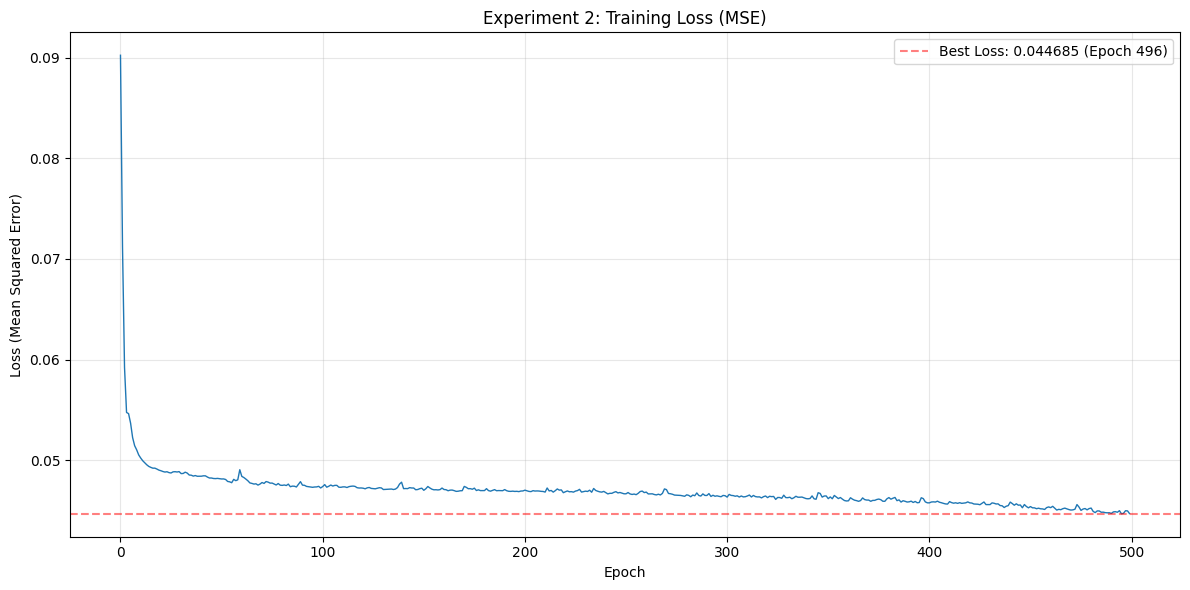


Training Statistics:
   Initial loss:  0.090233
   Final loss:    0.044705
   Best loss:     0.044685 (Epoch 496)
   Improvement:   50.5%


In [6]:
# Plot loss curve
plt.figure(figsize=(12, 6))
plt.plot(history_exp2.history['loss'], linewidth=1)
plt.title('Experiment 2: Training Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Mean Squared Error)')
plt.grid(True, alpha=0.3)

# Add statistics
min_loss_exp2 = min(history_exp2.history['loss'])
min_epoch_exp2 = history_exp2.history['loss'].index(min_loss_exp2)
plt.axhline(y=min_loss_exp2, color='r', linestyle='--', alpha=0.5,
            label=f'Best Loss: {min_loss_exp2:.6f} (Epoch {min_epoch_exp2+1})')
plt.legend()

plt.tight_layout()
plt.savefig('training_loss_curve_exp2.png', dpi=150, bbox_inches='tight')
plt.show()

# Print statistics
print(f"\nTraining Statistics:")
print(f"   Initial loss:  {history_exp2.history['loss'][0]:.6f}")
print(f"   Final loss:    {history_exp2.history['loss'][-1]:.6f}")
print(f"   Best loss:     {min_loss_exp2:.6f} (Epoch {min_epoch_exp2+1})")
print(f"   Improvement:   {((history_exp2.history['loss'][0] - history_exp2.history['loss'][-1]) / history_exp2.history['loss'][0] * 100):.1f}%")

Test Results:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


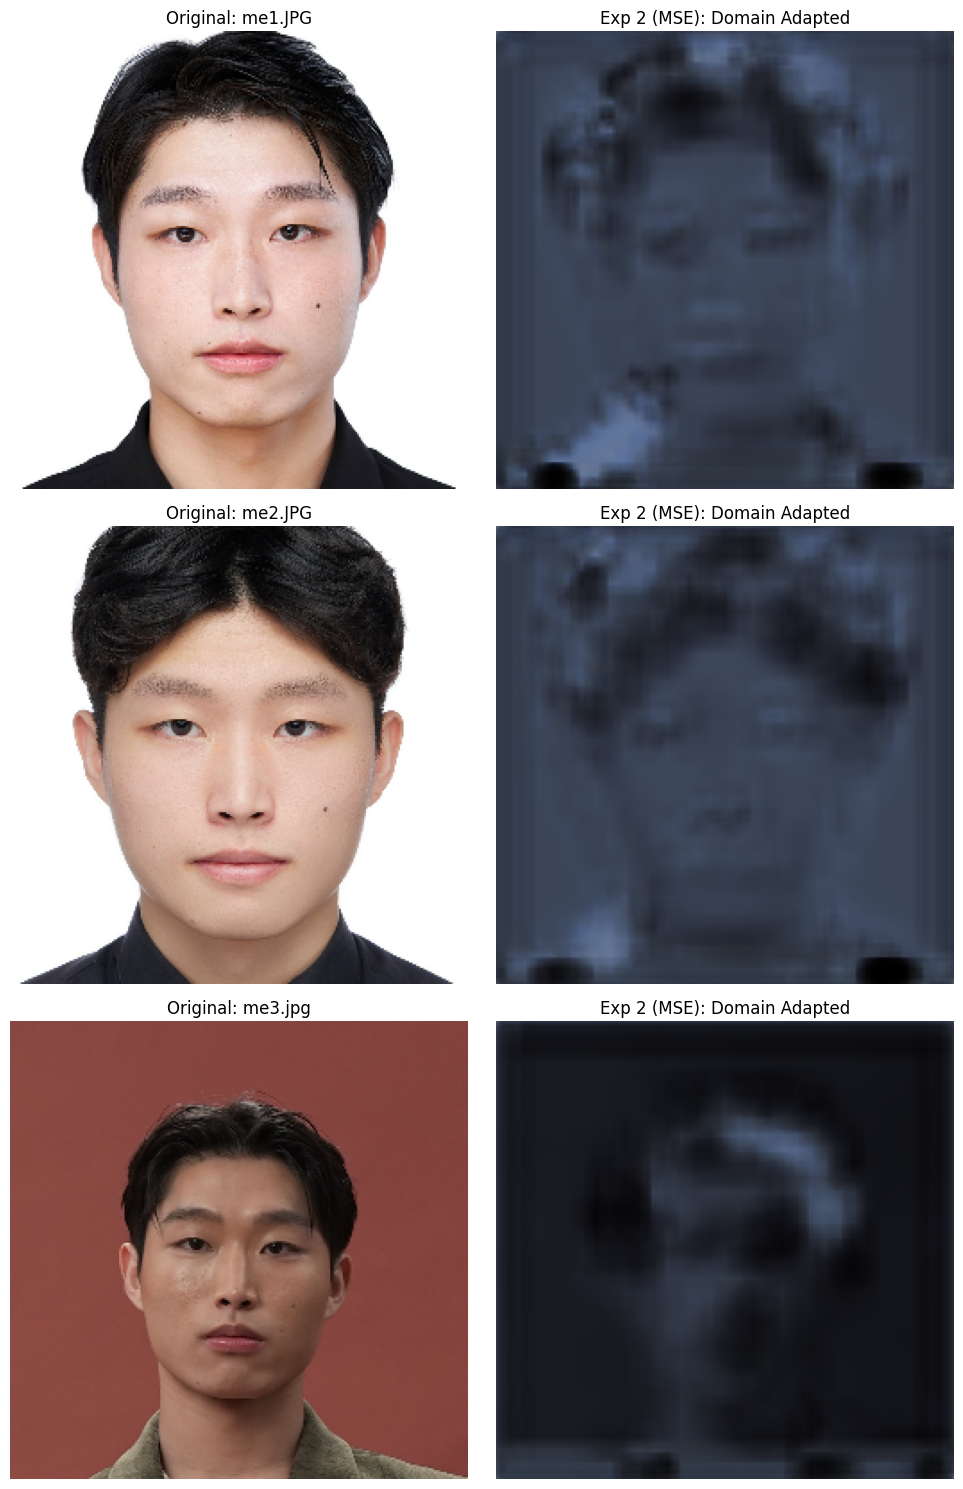

Results saved: domain_adaptation_results_exp2.png


In [ ]:
# Load trained model (Experiment 2)
model_exp2 = tf.keras.models.load_model('checkpoint_exp2_epoch_000400.keras')

# Load test images if not already loaded
if 'test_img_array' not in locals():
    test_img_data = []
    test_path = './data/me_cropped'
    test_files = sorted([f for f in os.listdir(test_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    
    for filename in test_files:
        img = cv2.imread(os.path.join(test_path, filename), 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (SIZE, SIZE))
        test_img_data.append(img_to_array(img))
    
    test_img_array = np.array(test_img_data).astype('float32') / 255.0

# Predict
predictions_exp2 = model_exp2.predict(test_img_array)

# Visualize
fig, axes = plt.subplots(len(test_files), 2, figsize=(10, 5 * len(test_files)))
if len(test_files) == 1:
    axes = axes.reshape(1, -1)

for i in range(len(test_files)):
    axes[i, 0].imshow(test_img_array[i])
    axes[i, 0].set_title(f'Original: {test_files[i]}')
    axes[i, 0].axis('off')
    
    axes[i, 1].imshow(predictions_exp2[i])
    axes[i, 1].set_title(f'Exp 2 (MSE): Domain Adapted')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.savefig('domain_adaptation_results_exp2.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Results saved: domain_adaptation_results_exp2.png")

Observations:

Output Quality: Sharper reconstructions compared to Exp 1, less blur

Analysis:
- MSE penalizes large errors quadratically
- Produces less blur than MAE

Limitations: Same as Exp 1 (300 images, 500 epochs, simple architecture)

Output Files: best_model_exp2_mse.keras, checkpoint_exp2_epoch_*.keras, final_model_exp2_mse_epochs_500.keras, training_loss_curve_exp2.png, domain_adaptation_results_exp2.png

---
**Changes from Sample Solution**

1. Final activation: `sigmoid` (not `relu`) - matches normalized range [0, 1]
2. Loss: Two experiments (MAE vs MSE) for comparison
3. Epochs: 1000 (not 100k) - professor confirmed flexible
4. Custom PeriodicCheckpoint callback - saves every 100 epochs
5. Caffeinate integration - prevents system sleep

---
**Experiment Comparison: MAE vs MSE**

Experimental Process:

1. Exp 1 (MAE): Started with MAE expecting clearer images, trained 1000 epochs with checkpoints every 100 epochs
2. Checkpoint Analysis: Compared visual quality across all checkpoints, found models around epoch 400-500 presented better results
3. Exp 1 Outcome: Despite optimal epoch selection, results showed blur and artifacts - not good enough
4. Exp 2 (MSE): Switched to MSE for better quality, trained only 500 epochs based on Exp 1 findings

Configuration:
- Architecture: Same (8,163 params), Batch: 32, Dataset: 300 images
- Difference: Loss function (MAE vs MSE), Epochs (1000 vs 500)

Results:
- Exp 1 (MAE, 1000 epochs): Final loss 0.156, blurry output with significant blue artifacts
- Exp 2 (MSE, 500 epochs): Final loss ~0.045, sharper reconstructions with fewer artifacts

Key Findings:

1. MSE significantly outperforms MAE
   - Initial expectation: MAE would produce clearer images
   - Reality: MAE produces blurry outputs with many artifacts
   - MSE delivers sharper results with cleaner reconstruction

2. Training efficiency improved
   - Exp 1 checkpoint comparison guided Exp 2 epoch selection
   - 500 epochs sufficient (based on 400-500 epoch sweet spot from Exp 1)
   - 100k epochs (original instruction): Unnecessary, confirmed by lecturer

3. Output quality limitations remain:
   - Small dataset (300 images)
   - Large domain gap (ethnicity + age)
   - Simple architecture (8 filters)

Conclusion:
Checkpoint-based analysis enabled efficient experimentation. MSE with 500 epochs provides best balance. Sample solution shows similar limitations, confirming inherent task difficulty.